# TRAINING A CLASSIFIER
[Pytorch:60分钟深度学习系列教程之4 训练一个分类器（数据集CIFAR-10）](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import traceback

数据一般加载到numpy中再转换为Tensor

* For images, packages such as Pillow, OpenCV are useful
* For audio, packages such as scipy and librosa
* For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

对于计算机视觉, torch 有个包 torchvision.可以方便地加载通用据集, 如 ImageNet, CIFAR10, MNIST等.

# Classifier

## 加载数据集

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

# 数据加载器
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True,
    num_workers=2)  # num_workers 2 个线程加载数据

# 测试集
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


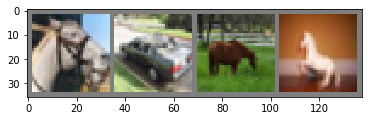

horse   car horse horse


In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # 原来 3 * (24*mini_batch_size) *(24*mini_batch_size), 把维度 换成 (24*mini_batch_size) * (24*mini_batch_size * 3)
    plt.show()


# 随机获取一些数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))  #多张图拼成一张图

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## CNN

In [4]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)  # 5x5

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))

        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
#         x = x.view(-1, self.num_flat_features(x))
        # hard code
        x = x.view(-1,400) #16 * 5 * 5

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一个不用激活？计算10个分类的可能性
        return x

    def num_flat_features(self, x):
        '''
        对于不固定的输入,可以使用这个函数, 这里的输入是固定的,直接hard code
        '''
        with torch.no_grad():
            size = x.size()[1:]  # 第0维是batch size，后面是特征维度
            num_features = 1
            for s in size:
                num_features *= s
            return num_features

           
class LeNet_3(nn.Module):
    def __init__(self):
        super(LeNet_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)  # 3x3
        self.conv2 = nn.Conv2d(6, 16, 3)  # 3x3

        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # max pool 2 2x2
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # 二维矩阵 转 向量
#         x = x.view(-1, self.num_flat_features(x))
        x = x.view(-1,576) #16 * 6 * 6

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一个不用激活？计算10个分类的可能性
        return x

    def num_flat_features(self, x):
        '''
        对于不固定的输入,可以使用这个函数, 这里的输入是固定的,直接hard code
        '''
        with torch.no_grad():
            size = x.size()[1:]  # 第0维是batch size，后面是特征维度
            num_features = 1
            for s in size:
                num_features *= s
            return num_features

In [5]:
class LeNet(nn.Module):
    def __init__(self,size=3,optimizer=None):
        '''
        size 卷积核大小
        '''
        super(LeNet, self).__init__()
        if size != 3 and size !=5:
            print("Warning! size:{}. set to 3".format(size))
            sise = 3
        
        self.size=size
        
        self.conv1 = nn.Conv2d(3, 6, size)  # 3x3
        self.conv2 = nn.Conv2d(6, 16, size)  # 3x3

        if size == 3:
            self.fc1 = nn.Linear(16 * 6 * 6, 120)
        else:
            # 5
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # GPU
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
        # 损失函数 与 优化器
        self.criterion = nn.CrossEntropyLoss()  # 交叉熵
        
        if optimizer == None:
            self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        else:
            self.optimizer = optimizer

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # max pool 2 2x2
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # 二维矩阵 转 向量
        if self.size == 3:
            x = x.view(-1, 576)
        else:
            x = x.view(-1, 400)
        # x = x.view(-1, self.num_flat_features(x))
            
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

    def num_flat_features(self, x):
        '''
        对于不固定的输入,可以使用这个函数, 这里的输入是固定的,直接hard code
        '''
        with torch.no_grad():
            size = x.size()[1:]  # 第0维是batch size，后面是特征维度
            num_features = 1
            for s in size:
                num_features *= s
            return num_features
        
    def batch_train(self,x,y):
        inputs, labels = x.to(self.device), y.to(self.device)
    
        self.optimizer.zero_grad()
        outputs = self.forward(inputs) # self(inputs)??

        loss = self.criterion(outputs, labels)  # 最后得到一个标量,loss
        loss.backward()

        self.optimizer.step()  # 这里更新了参数

        return outputs,loss
    
    
    def test(self,x):
        inputs = x.to(self.device)
        with torch.no_grad():
            outputs = self.forward(inputs) # self(inputs)??
            return outputs
        
    def dataset_test(self, testloader):
        correct = 0
        total = 0
        accuracy = 0.0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(self.device),data[1].to(self.device)
                outputs = self.test(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()    
        accuracy = 100 * correct / total
        return correct, total, accuracy

In [ ]:
ln3 = LeNet(3)
for epoch in range(10):  # 数据集的循环次数

    running_loss3 = 0.0  # 运行时的损失的值(2000次loss的均值),记录损失的下降趋势
    for i, data in enumerate(trainloader, 0):  # enumerate(sequence, [start=0])

        inputs, labels = data
        
        outputs3,loss3 = ln3.batch_train(inputs,labels)
        running_loss3 += loss3.item() 
    
        # log statistics
        if i % 2000 == 1999:
            print('[%d, %5d] loss LeNet3: %.3f' %(epoch + 1, i + 1, running_loss3 / 2000))
            running_loss3 = 0.0

print('Finished Training')

[1,  2000] loss LeNet3: 2.258
[1,  4000] loss LeNet3: 2.004
[1,  6000] loss LeNet3: 1.828
[1,  8000] loss LeNet3: 1.687
[1, 10000] loss LeNet3: 1.576
[1, 12000] loss LeNet3: 1.516
[2,  2000] loss LeNet3: 1.452
[2,  4000] loss LeNet3: 1.428
[2,  6000] loss LeNet3: 1.379
[2,  8000] loss LeNet3: 1.381


In [ ]:
correct3, total3, acc3 = ln3.dataset_test(testloader)
print('Accuracy of the LeNet-3 on the 10000 test images: %d %%' % acc3)

In [8]:
ln5 = LeNet(5)
for epoch in range(10):  # 数据集的循环次数

    running_loss5 = 0.0
    for i, data in enumerate(trainloader, 0):  # enumerate(sequence, [start=0])

        inputs, labels = data
        
        outputs5,loss5 = ln5.batch_train(inputs,labels)
        running_loss5 += loss5.item()

        # log statistics
        if i % 2000 == 1999:
            print('[%d, %5d] loss LeNet5: %.3f' %(epoch + 1, i + 1, running_loss5 / 2000))
            running_loss5 = 0.0

print('Finished Training')

[1,  2000] loss LeNet5: 2.201
[1,  4000] loss LeNet5: 1.877
[1,  6000] loss LeNet5: 1.665
[1,  8000] loss LeNet5: 1.586
[1, 10000] loss LeNet5: 1.522
[1, 12000] loss LeNet5: 1.470
[2,  2000] loss LeNet5: 1.403
[2,  4000] loss LeNet5: 1.366
[2,  6000] loss LeNet5: 1.346
[2,  8000] loss LeNet5: 1.320
[2, 10000] loss LeNet5: 1.288
[2, 12000] loss LeNet5: 1.288
[3,  2000] loss LeNet5: 1.194
[3,  4000] loss LeNet5: 1.228
[3,  6000] loss LeNet5: 1.195
[3,  8000] loss LeNet5: 1.198
[3, 10000] loss LeNet5: 1.181
[3, 12000] loss LeNet5: 1.204
[4,  2000] loss LeNet5: 1.102
[4,  4000] loss LeNet5: 1.118
[4,  6000] loss LeNet5: 1.105
[4,  8000] loss LeNet5: 1.102
[4, 10000] loss LeNet5: 1.128
[4, 12000] loss LeNet5: 1.097
[5,  2000] loss LeNet5: 1.027
[5,  4000] loss LeNet5: 1.042
[5,  6000] loss LeNet5: 1.030
[5,  8000] loss LeNet5: 1.031
[5, 10000] loss LeNet5: 1.056
[5, 12000] loss LeNet5: 1.052
[6,  2000] loss LeNet5: 0.968
[6,  4000] loss LeNet5: 0.960
[6,  6000] loss LeNet5: 0.992
[6,  8000]

In [9]:
correct5 ,total5 ,acc5 = ln5.dataset_test(testloader)
print('Accuracy of the LeNet-5 on the 10000 test images: %d %%' % acc5)

Accuracy of the LeNet-5 on the 10000 test images: 61 %
